In [282]:
import sys
sys.path.append('../src')
import scipy.io
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from world import Patch, Agent
import logging
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from mvt_brr import MVTModel

import matplotlib
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)

In [2]:
from analytical_model_fit import load_data, group_data
from utils import calculate_aic_bic, calculate_subject_aic_bic

In [3]:
patches = {
    'low': Patch(32.5, 0.075, 'exponential'),
    'med': Patch(45, 0.075, 'exponential'),
    'high': Patch(57.5, 0.075, 'exponential')
}

In [3]:
df_trials, block_order_df, data = load_data()

# Group data
grouped_df = group_data(df_trials)

2024-08-23 10:45:11,452 - INFO - Loading data...
2024-08-23 10:45:11,472 - INFO - Grouping trial data by subject, environment, and patch...


In [5]:
policy_type = "mellowmax"
mellowmax_type = 'add' if policy_type == 'mellowmax' else None

### Visualizing Fits

In [14]:
policy_type = "mellowmax"
mellowmax_type = "add"
path = f"../src/optimization_results_{policy_type}_{mellowmax_type}.csv"

In [15]:
res_df = pd.read_csv(path)

In [16]:
res_df[res_df["sub"]==3]

,sub,env,case,policy_type,fitted_parameter,fitted_intercept,predicted_leaveT,actual_mean_leaveT
4,3,1,fix_parameter_fix_c,mellowmax,0.889794,-17.754732,19.395503,16.733743
5,3,2,fix_parameter_fix_c,mellowmax,0.889794,-17.754732,17.521906,20.564042
82,3,1,vary_parameter_vary_c,mellowmax,0.682923,-26.586137,16.851671,16.733743
83,3,2,vary_parameter_vary_c,mellowmax,1.235322,-11.958340,20.686397,20.564042
160,3,1,vary_parameter_fix_c,mellowmax,0.669663,-17.754732,16.807775,16.733743
161,3,2,vary_parameter_fix_c,mellowmax,1.237001,-17.754732,20.605334,20.564042
238,3,1,fix_parameter_vary_c,mellowmax,0.889794,-3793.402649,16.985273,16.733743
239,3,2,fix_parameter_vary_c,mellowmax,0.889794,2.295931,20.511079,20.564042


In [358]:
def plot_environment_case(data, case_name, actual_col, predicted_col, var_plot):
    # Filter data for the specific case
    case_data = data[data['case'] == case_name]
    
    # Plot settings
    fig, axes = plt.subplots(1, 2, figsize=(4, 3.5), sharex=True, sharey=True)
    
    # Define colors for the environments
    colors = {1: 'blue', 2: 'green'}
    
    # Loop through each environment (1 and 2)
    for env, ax in zip([1, 2], axes):
        # Filter data for the environment
        env_data = case_data[case_data['env'] == env]
        
        # Calculate correlation
        r, _ = pearsonr(env_data[actual_col], env_data[predicted_col])
        
        # Scatter plot with specified color
        sns.scatterplot(
            x=actual_col, y=predicted_col, data=env_data, ax=ax,
            color=colors[env]
        )
        
        # Plot a line for y=x
        ax.plot([0, env_data[actual_col].max()], 
                [0, env_data[predicted_col].max()], 
                'k--', lw=2)
        
        # Display r value on the middle left of the plot without a box
        ax.text(
            0.30, 0.85, f'r = {r:.2f}',
            transform=ax.transAxes, fontsize=16, verticalalignment='center', horizontalalignment='center'
        )
        
        # Set title and labels
        print(f'{case_name} - {"Rich" if env == 1 else "Poor"} \nr = {r:.4f}')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    if var_plot:
        plt_text = r'SD$_{\mathrm{leave}}$ (s)'
    else:
        plt_text = 'Leaving Times (s)'

    fig.text(0.5, 0.0, 'Subject' + " " + plt_text, ha='center', fontsize=16)
    fig.text(-0.015, 0.5, 'Model' + " " + plt_text, va='center', rotation='vertical', fontsize=16)
    
    # Add case name text in the upper left of the plot
    case_name_mapping = {
        "fix_parameter_fix_c": r"fix $\beta$ fix c",
        "vary_parameter_vary_c": r"vary $\beta$ vary c",
        "vary_parameter_fix_c": r"vary $\beta$ fix c",
        "fix_parameter_vary_c": r"fix $\beta$ vary c",
        "no_intercept": "no intercept"
    }
    fig.text(0.5, 0.95, case_name_mapping.get(case_name, case_name), fontsize=16, ha='center')

    plt.tight_layout()
    plt.show()

# For softmax (analytical fits)

In [318]:
res_soft_df = pd.read_csv("../src/optimization_results_softmax.csv")
res_soft_df[res_soft_df["sub"]==3]

,sub,env,case,policy_type,fitted_parameter,fitted_intercept,predicted_leaveT,actual_mean_leaveT,predicted_std_leaveT,actual_std_leaveT
4,3,1,fix_parameter_fix_c,softmax,0.073163,1.474161,19.548446,16.733743,8.517260,1.652903
5,3,2,fix_parameter_fix_c,softmax,0.073163,1.474161,17.257057,20.564042,7.239171,2.007353
82,3,1,vary_parameter_vary_c,softmax,0.364397,-4.343233,16.733739,16.733743,5.895318,1.652903
83,3,2,vary_parameter_vary_c,softmax,0.801783,-6.513515,20.564046,20.564042,6.193638,2.007353
160,3,1,vary_parameter_fix_c,softmax,0.057667,1.474161,16.892092,16.733743,7.746407,1.652903
161,3,2,vary_parameter_fix_c,softmax,0.098474,1.474161,20.654309,20.564042,8.154230,2.007353
238,3,1,fix_parameter_vary_c,softmax,0.073163,1.126248,16.765131,16.733743,7.308722,1.652903
239,3,2,fix_parameter_vary_c,softmax,0.073163,1.829577,20.597678,20.564042,8.749037,2.007353
316,3,1,no_intercept,softmax,0.364397,0.000000,30.595249,16.733743,11.014192,1.652903
317,3,2,no_intercept,softmax,0.809460,0.000000,38.529268,20.564042,12.735959,2.007353


fix_parameter_fix_c - Rich 
r = 0.9706
fix_parameter_fix_c - Poor 
r = 0.9497


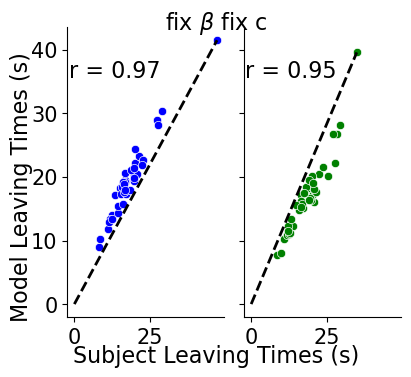

vary_parameter_vary_c - Rich 
r = 1.0000
vary_parameter_vary_c - Poor 
r = 1.0000


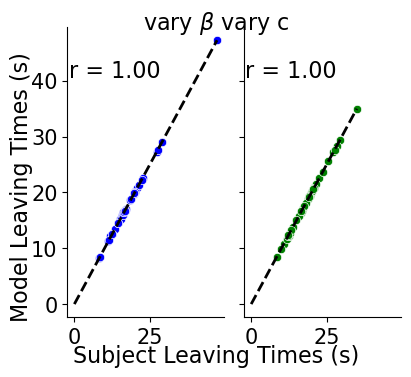

vary_parameter_fix_c - Rich 
r = 0.9998
vary_parameter_fix_c - Poor 
r = 0.9999


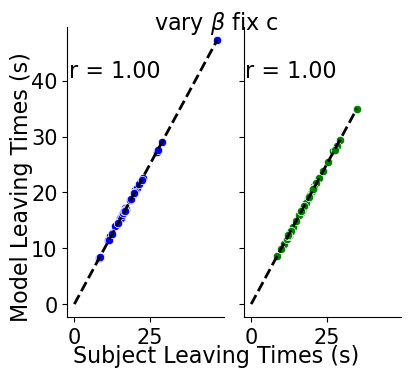

fix_parameter_vary_c - Rich 
r = 0.9999
fix_parameter_vary_c - Poor 
r = 1.0000


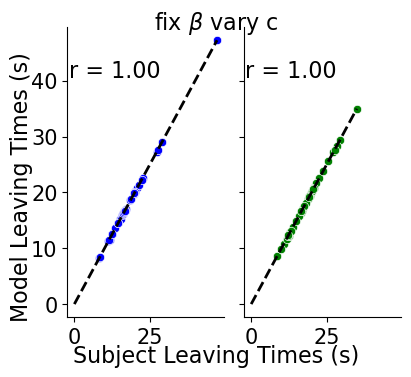

no_intercept - Rich 
r = 0.0376
no_intercept - Poor 
r = -0.1422


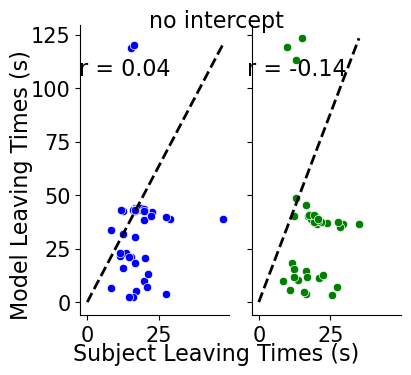

In [359]:
# Loop through all cases and plot
for case in res_soft_df['case'].unique():
    plot_environment_case(res_soft_df, case, 'actual_mean_leaveT', 'predicted_leaveT', False)

### Model fit's performance on standard deviation of leave times (Softmax)

fix_parameter_fix_c - Rich 
r = 0.2351
fix_parameter_fix_c - Poor 
r = 0.4243


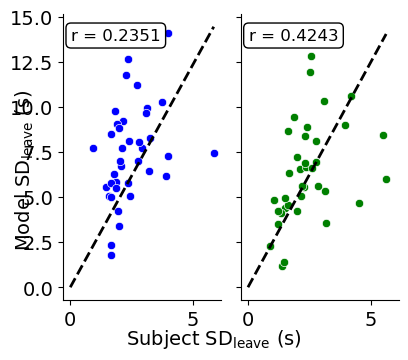

vary_parameter_vary_c - Rich 
r = 0.2172
vary_parameter_vary_c - Poor 
r = 0.3939


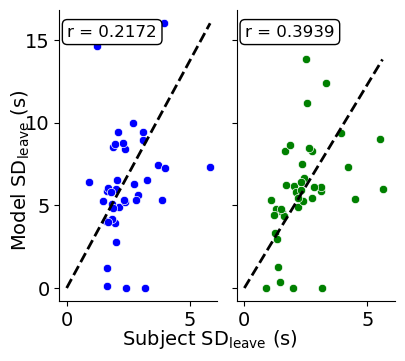

vary_parameter_fix_c - Rich 
r = 0.2445
vary_parameter_fix_c - Poor 
r = 0.4113


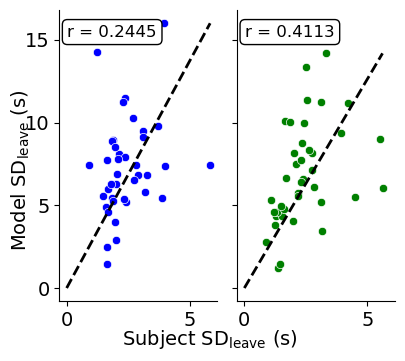

fix_parameter_vary_c - Rich 
r = 0.2618
fix_parameter_vary_c - Poor 
r = 0.3755


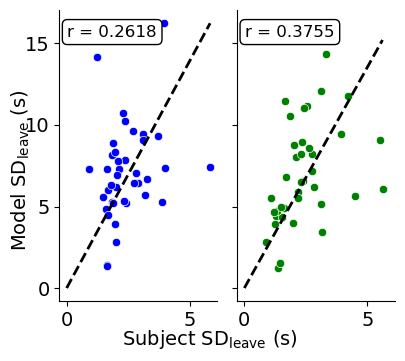

no_intercept - Rich 
r = 0.2518
no_intercept - Poor 
r = 0.0097


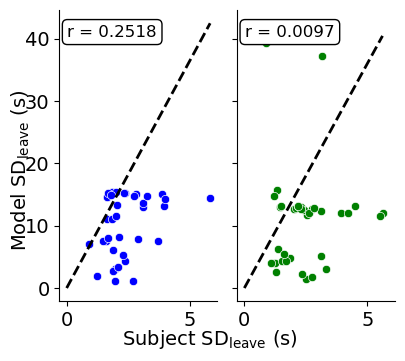

In [238]:
for case in res_soft_df['case'].unique():
    plot_environment_case(res_soft_df, case, 'actual_std_leaveT', 'predicted_std_leaveT', True)

# Mellowmax Add

In [348]:
res_mellow_df = pd.read_csv("../src/optimization_results_mellowmax_add_new.csv")
res_mellow_df[res_mellow_df["sub"]==3]

,sub,env,case,policy_type,fitted_parameter,fitted_intercept,predicted_leaveT,actual_mean_leaveT,predicted_std_leaveT,actual_std_leaveT
4,3,1,fix_parameter_fix_c,mellowmax,0.889794,-17.754732,19.395503,16.733743,8.402664,1.652903
5,3,2,fix_parameter_fix_c,mellowmax,0.889794,-17.754732,17.521906,20.564042,7.017473,2.007353
82,3,1,vary_parameter_vary_c,mellowmax,0.682923,-26.586137,16.851671,16.733743,7.394955,1.652903
83,3,2,vary_parameter_vary_c,mellowmax,1.235322,-11.958340,20.686397,20.564042,8.209249,2.007353
160,3,1,vary_parameter_fix_c,mellowmax,0.669663,-17.754732,16.807775,16.733743,7.426916,1.652903
161,3,2,vary_parameter_fix_c,mellowmax,1.237001,-17.754732,20.605334,20.564042,8.138271,2.007353
238,3,1,fix_parameter_vary_c,mellowmax,0.889794,-3793.402649,16.985273,16.733743,6.791911,1.652903
239,3,2,fix_parameter_vary_c,mellowmax,0.889794,2.295931,20.511079,20.564042,12.741361,2.007353
316,3,1,no_intercept,mellowmax,0.668361,0.000000,17.370338,16.733743,7.915210,1.652903
317,3,2,no_intercept,mellowmax,1.286250,0.000000,21.506002,20.564042,8.718652,2.007353


fix_parameter_fix_c - Rich 
r = 0.9702
fix_parameter_fix_c - Poor 
r = 0.9446


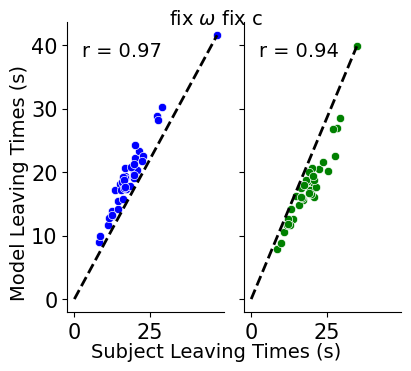

vary_parameter_vary_c - Rich 
r = 0.9999
vary_parameter_vary_c - Poor 
r = 0.9998


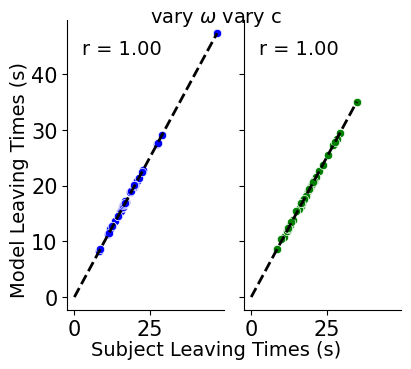

vary_parameter_fix_c - Rich 
r = 0.9951
vary_parameter_fix_c - Poor 
r = 0.9999


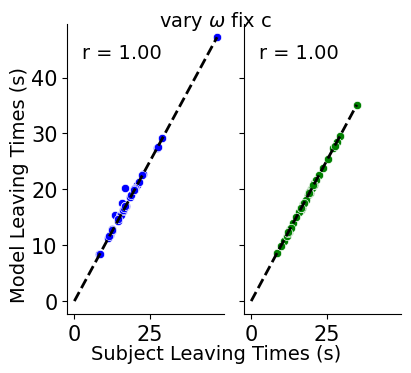

fix_parameter_vary_c - Rich 
r = 0.9883
fix_parameter_vary_c - Poor 
r = 0.9936


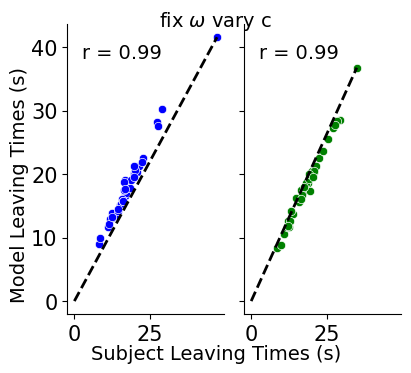

no_intercept - Rich 
r = 0.9618
no_intercept - Poor 
r = 0.9510


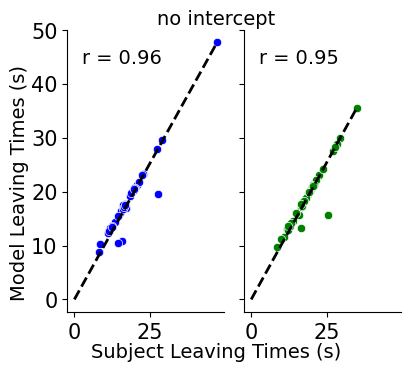

In [351]:
# Loop through all cases and plot
for case in res_mellow_df['case'].unique():
    plot_environment_case(res_mellow_df, case, 'actual_mean_leaveT', 'predicted_leaveT', False)

### Model fit's performance on standard deviation of leave times (Mellowmax)

fix_parameter_fix_c - Rich 
r = 0.1809
fix_parameter_fix_c - Poor 
r = 0.4310


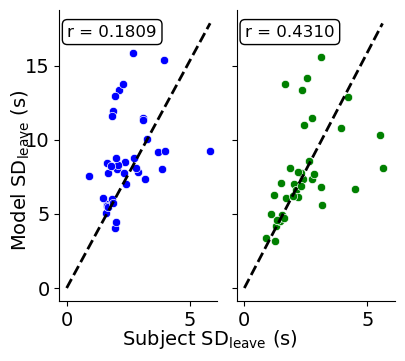

vary_parameter_vary_c - Rich 
r = 0.2556
vary_parameter_vary_c - Poor 
r = 0.4428


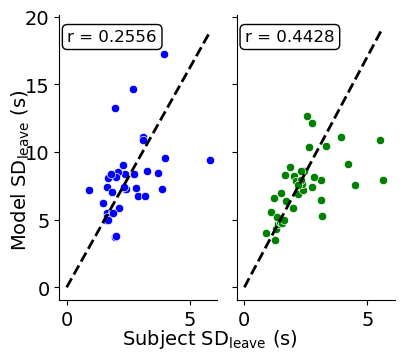

vary_parameter_fix_c - Rich 
r = 0.1774
vary_parameter_fix_c - Poor 
r = 0.4473


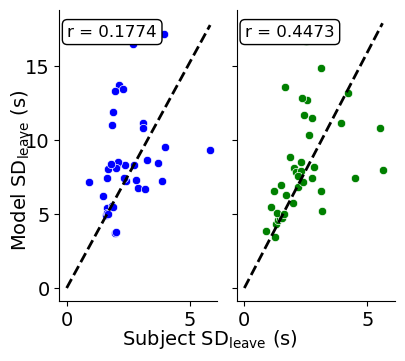

fix_parameter_vary_c - Rich 
r = 0.2323
fix_parameter_vary_c - Poor 
r = 0.3398


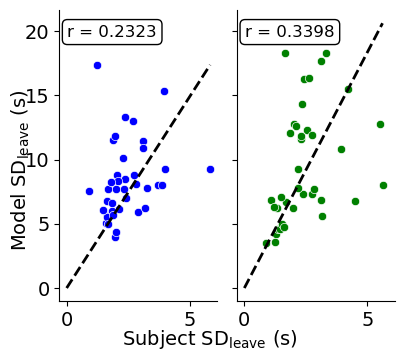

no_intercept - Rich 
r = 0.5065
no_intercept - Poor 
r = 0.5654


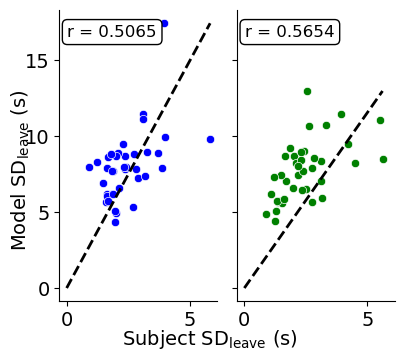

In [239]:
for case in res_mellow_df['case'].unique():
    plot_environment_case(res_mellow_df, case, 'actual_std_leaveT', 'predicted_std_leaveT', True)

In [504]:
from scipy.stats import ttest_rel

def plot_fitted_parameter_comparison(df, case_name, parameter='fitted_intercept'):
    """
    Plots the comparison of the fitted parameter (intercept or another parameter) 
    between two environments for each subject for a specific case, and includes paired t-test results.

    Parameters:
    df (pd.DataFrame): The dataframe containing the results.
    case_name (str): The specific case to filter by.
    parameter (str): The parameter to plot ('fitted_intercept' or 'fitted_parameter').
    """
    # Filter the dataframe for the specific case
    ylim = (-0.1, 4)
    case_df = df[(df['case'] == case_name) & (~df['sub'].isin([1]))]
    print(len(case_df))

    # Separate the data into rich and poor environments
    rich_data = case_df[case_df['env'] == 1][parameter]
    poor_data = case_df[case_df['env'] == 2][parameter]
    print(len(rich_data), len(poor_data))
    # Perform paired t-test
    t_stat, p_val = ttest_rel(rich_data, poor_data)

    # Initialize the plot with a narrower width to reduce the gap between xticks
    plt.figure(figsize=(2.5, 4))

    points_within_ylim = 0
    
    # Plot the points and lines for each subject across the two environments
    for sub in case_df['sub'].unique():
        sub_data = case_df[case_df['sub'] == sub]

        for value in sub_data[parameter]:
            if ylim[0] <= value <= ylim[1]:
                points_within_ylim += 1
        
        # Plot the grey line connecting the points
        plt.plot([0, 1], sub_data[parameter], marker='o', color='grey', linestyle='-', alpha=0.5, zorder=1)
        
        # Scatter the points for each environment with blue and green colors
        plt.scatter([0, 1], sub_data[parameter], c=sub_data['env'].map({1: 'blue', 2: 'green'}), s=50, zorder=2)

    # Set labels
    plt.ylabel(r'$\omega$ (higher = exploit)', fontsize=14)
    plt.xticks([0, 1], ['Rich', 'Poor'], fontsize=14)

    # Set limits for y-axis to match the screenshot (adjust as needed)
    plt.ylim(-0.1, 3.2)
    
    # Adjust the spacing between the xticks by limiting the plot width
    plt.xlim(-0.5, 1.5)

    # Display t-statistic and p-value on the plot
    plt.text(0.4, 3, f'p = {p_val:.1e}', ha='center', fontsize=14)

    # Remove top and right spines
    sns.despine()

    # Show the plot with tight layout
    plt.tight_layout()
    plt.show()

76
38 38


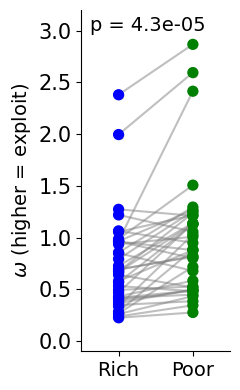

In [505]:
plot_fitted_parameter_comparison(res_mellow_df, case_name='vary_parameter_fix_c', parameter='fitted_parameter')

76
38 38


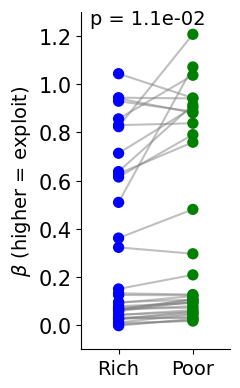

In [503]:
plot_fitted_parameter_comparison(res_soft_df, case_name='vary_parameter_fix_c', parameter='fitted_parameter')

In [315]:
def calculate_model_leave_times_for_patch_types(case_df, patch_types):
    results = []

    for _, row in case_df.iterrows():
        for patch_type in patch_types:
            patch = Patch(initial_yield=patch_type['initial_yield'], decay_rate=patch_type['decay_rate'])
            expected_leave_time, _ = calculate_leave_statistics(
                policy_type=row['policy_type'], 
                parameter=row['fitted_parameter'], 
                intercept=row['fitted_intercept'], 
                patch=patch,
                mellowmax_type='add'
            )
            results.append({
                'sub': row['sub'],
                'env': row['env'],
                'patch': patch_type['type'],
                'predicted_leave_time': expected_leave_time
            })

    return pd.DataFrame(results)

def plot_model_and_actual_patch_leaving_time_by_patch_type(res_df, case_name, df_trials_agg, MVT_rich, MVT_poor):
    case_name_mapping = {
        "fix_parameter_fix_c": r"fix $\omega$ fix c",
        "vary_parameter_vary_c": r"vary $\omega$ vary c",
        "vary_parameter_fix_c": r"vary $\omega$ fix c",
        "fix_parameter_vary_c": r"fix $\omega$ vary c",
        "no_intercept": "c = 0"
    }
    patch_types = [
        {'type': 1, 'initial_yield': 32.5, 'decay_rate': 0.075},
        {'type': 2, 'initial_yield': 45, 'decay_rate': 0.075},
        {'type': 3, 'initial_yield': 57.5, 'decay_rate': 0.075}
    ]
    
    case_df = res_df[res_df['case'] == case_name]
    
    # Calculate predicted leave times for each subject and patch type
    predicted_df = calculate_model_leave_times_for_patch_types(case_df, patch_types)
    
    # Merge predicted data with actual data
    merged_df = pd.merge(predicted_df, df_trials_agg, on=['sub', 'env', 'patch'], how='left')
    
    # Aggregate data to calculate mean and SEM for both actual and predicted leave times
    rich_data = merged_df[merged_df['env'] == 1]
    poor_data = merged_df[merged_df['env'] == 2]
    
    mean_actual_rich = rich_data.groupby('patch')['mean_leaveT'].mean()
    sem_actual_rich = rich_data.groupby('patch')['mean_leaveT'].sem()
    
    mean_predicted_rich = rich_data.groupby('patch')['predicted_leave_time'].mean()
    sem_predicted_rich = rich_data.groupby('patch')['predicted_leave_time'].sem()
    
    mean_actual_poor = poor_data.groupby('patch')['mean_leaveT'].mean()
    sem_actual_poor = poor_data.groupby('patch')['mean_leaveT'].sem()
    
    mean_predicted_poor = poor_data.groupby('patch')['predicted_leave_time'].mean()
    sem_predicted_poor = poor_data.groupby('patch')['predicted_leave_time'].sem()
    
    conditions = ['Low', 'Mid', 'High']
    
    plt.figure(figsize=(4, 4))

    # Plot MVT lines
    plt.plot(conditions, MVT_rich, linestyle='--', color='grey')
    plt.plot(conditions, MVT_poor, linestyle='--', color='grey')

    # Plot actual data
    plt.errorbar(conditions, mean_actual_rich, yerr=sem_actual_rich, fmt='s-', color='blue', label='Subjects (Rich)')
    plt.errorbar(conditions, mean_actual_poor, yerr=sem_actual_poor, fmt='s-', color='green', label='Subjects (Poor)')

    # Plot predicted data
    plt.errorbar(conditions, mean_predicted_rich, yerr=sem_predicted_rich, fmt='o--', color='blue', label='Models (Rich)')
    plt.errorbar(conditions, mean_predicted_poor, yerr=sem_predicted_poor, fmt='o--', color='green', label='Models (Poor)')

    # Customize plot
    plt.ylabel('Patch leaving time (s)', fontsize=15)
    plt.xticks(ticks=range(len(conditions)), labels=conditions, fontsize=15)
    plt.ylim(0, 30)
    plt.legend(loc='lower right', fontsize=13)
    plt.text(0.7, 28, case_name_mapping.get(case_name, case_name), fontsize=15, ha='center', va='top')
    sns.despine()
    plt.tight_layout()
    plt.show()

In [113]:
def calculate_leave_statistics(policy_type, parameter, intercept, patch, mellowmax_type=None, max_timesteps=200, use_intercept=True):
    if policy_type == 'epsilon_greedy':
        epsilon = parameter
        expected_leave_time = 1 / epsilon
        variance_leave_time = (1 - epsilon) / (epsilon ** 2)
        std_leave_time = np.sqrt(variance_leave_time)
        return expected_leave_time, std_leave_time
    
    agent_kwargs = {
        'policy_type': policy_type,
        'beta': parameter if policy_type == 'softmax' else None,
        'intercept': intercept,
        'omega': parameter if policy_type == 'mellowmax' else None,
        'use_intercept': use_intercept
    }
    if policy_type == 'mellowmax':
        agent_kwargs['mellowmax_type'] = mellowmax_type

    agent = Agent(**agent_kwargs)

    patch.start_harvesting()
    expected_leave_time = 0.0
    variance_leave_time = 0.0
    cumulative_prob = 1.0

    for n in range(1, max_timesteps + 1):
        reward = patch.get_reward()
        prob_leave_now = agent.get_leave_probability(reward)
        p_leave_n = prob_leave_now * cumulative_prob
        
        # Expected leave time E(leave)
        expected_leave_time += n * p_leave_n
        
        # Variance of leave time VAR(leave)
        variance_leave_time += ((n - expected_leave_time) ** 2) * p_leave_n
        
        # Update cumulative probability
        cumulative_prob *= (1 - prob_leave_now)
    
    std_leave_time = np.sqrt(variance_leave_time)
    return expected_leave_time, std_leave_time

fix_parameter_fix_c


/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:108: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  beta_hat = fsolve(root_function, initial_guess)
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:93: RuntimeWarning: invalid value encountered in log
  return np.log(np.mean(np.exp(self.omega * Q_values) + self.intercept)) / self.omega
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:108: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  beta_hat = fsolve(root_function, initial_guess)
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:128: RuntimeWarning: overflow encountered in exp
  leave_proba = 1 / (1 + 

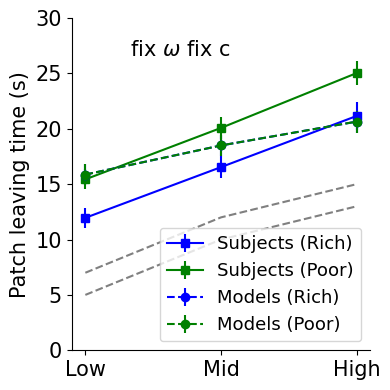

vary_parameter_vary_c


/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:93: RuntimeWarning: invalid value encountered in log
  return np.log(np.mean(np.exp(self.omega * Q_values) + self.intercept)) / self.omega
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:108: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  beta_hat = fsolve(root_function, initial_guess)
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:108: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  beta_hat = fsolve(root_function, initial_guess)
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:128: RuntimeWarning: overflow encountered in exp
  leave_proba = 1 / (1 + 

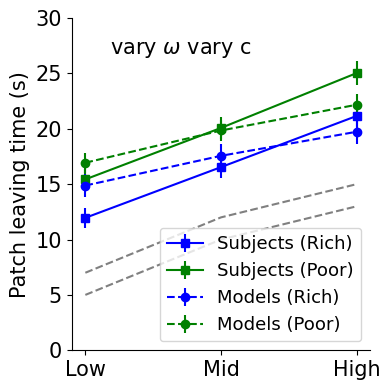

vary_parameter_fix_c


/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:93: RuntimeWarning: invalid value encountered in log
  return np.log(np.mean(np.exp(self.omega * Q_values) + self.intercept)) / self.omega
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:108: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  beta_hat = fsolve(root_function, initial_guess)
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:108: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  beta_hat = fsolve(root_function, initial_guess)
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:128: RuntimeWarning: overflow encountered in exp
  leave_proba = 1 / (1 + 

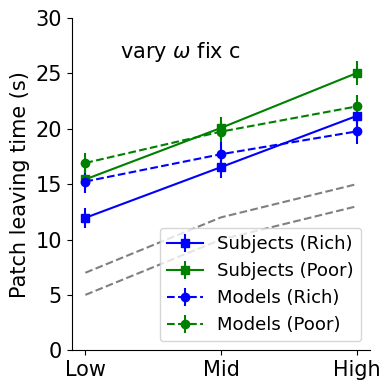

fix_parameter_vary_c


/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:93: RuntimeWarning: invalid value encountered in log
  return np.log(np.mean(np.exp(self.omega * Q_values) + self.intercept)) / self.omega
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:108: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  beta_hat = fsolve(root_function, initial_guess)
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:108: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  beta_hat = fsolve(root_function, initial_guess)
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:128: RuntimeWarning: overflow encountered in exp
  leave_proba = 1 / (1 + 

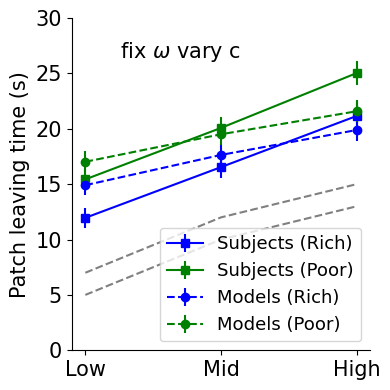

no_intercept


/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:108: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  beta_hat = fsolve(root_function, initial_guess)


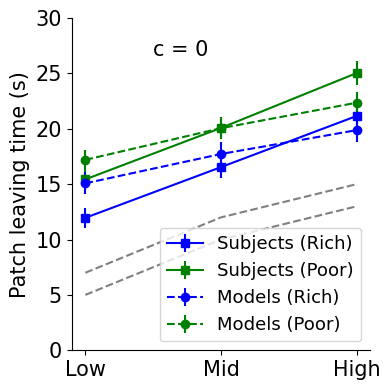

In [316]:
model = MVTModel(decay_type='exponential')
MVT_rich, MVT_poor = model.run()
df_trials = pd.read_csv("../leheron_trialbytrial/leheron_trialbytrial.csv")
df_trials_agg = df_trials.groupby(['sub', 'env', 'patch']).agg(
    mean_leaveT=('leaveT','mean'),
    std_leaveT=('leaveT','std')
).reset_index()

for case in res_mellow_df['case'].unique():
    print(case)
    plot_model_and_actual_patch_leaving_time_by_patch_type(res_mellow_df, case, df_trials_agg, MVT_rich, MVT_poor)

fix_parameter_fix_c


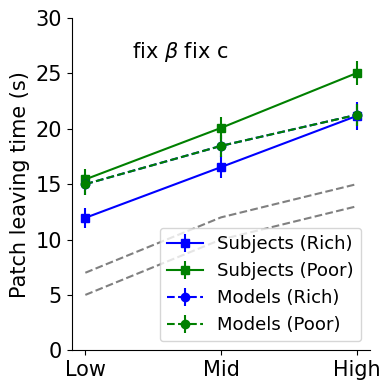

vary_parameter_vary_c


/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:73: RuntimeWarning: overflow encountered in exp
  def choose_action_softmax(self, reward):


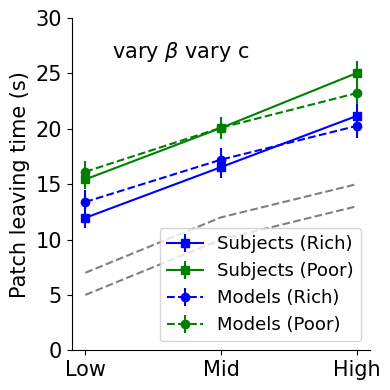

vary_parameter_fix_c


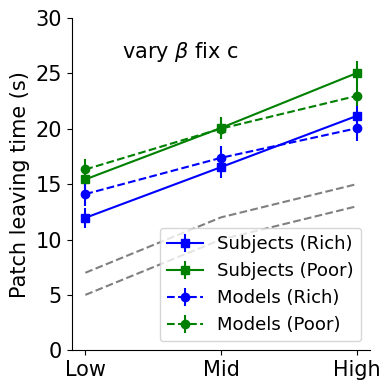

fix_parameter_vary_c


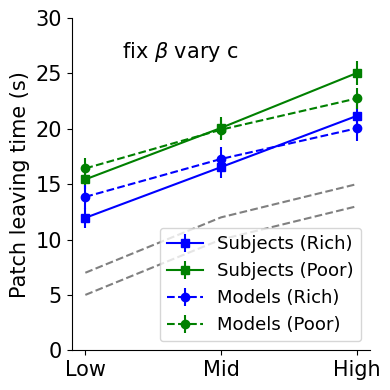

no_intercept


/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:73: RuntimeWarning: overflow encountered in exp
  def choose_action_softmax(self, reward):


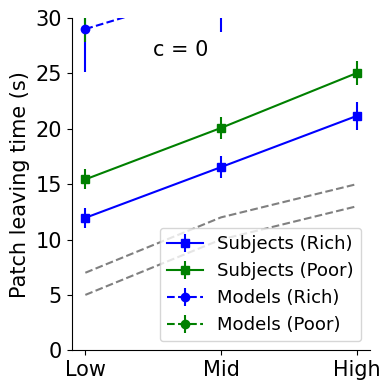

In [314]:
for case in res_soft_df['case'].unique():
    print(case)
    plot_model_and_actual_patch_leaving_time_by_patch_type(res_soft_df, case, df_trials_agg, MVT_rich, MVT_poor)

In [280]:
def plot_fitted_parameter_vs_leave_time(res_df, case_name, parameter='fitted_parameter'):
    """
    Plots the selected fitted parameter against the actual subject leave time for each environment
    for a given case.
    
    Parameters:
    res_df (pd.DataFrame): DataFrame containing 'env', 'case', 'fitted_parameter', 'actual_mean_leaveT'.
    case_name (str): The specific case to filter the data.
    parameter (str): The parameter to plot (e.g., 'fitted_parameter' or 'fitted_intercept').
    """
    # Filter the dataframe for the specific case
    case_df = res_df[res_df['case'] == case_name]

    # Initialize the plot
    plt.figure(figsize=(4, 4))
    
    # Plot data for Rich environment (env = 1) and Poor environment (env = 2)
    sns.scatterplot(data=case_df[case_df['env'] == 1], 
                    x='actual_mean_leaveT', y=parameter, 
                    color='blue', label='Rich', s=50, alpha=0.7)
    
    sns.scatterplot(data=case_df[case_df['env'] == 2], 
                    x='actual_mean_leaveT', y=parameter, 
                    color='green', label='Poor', s=50, alpha=0.7)

    # Labels and limits
    plt.xlabel('Subject leaving times (s)', fontsize=14)
    # plt.ylabel(f'Estimated {parameter.replace("_", " ")}', fontsize=14)
    plt.ylabel(r'Estimated $\beta$', fontsize=14)
    # plt.ylabel(r'Estimated $\omega$', fontsize=14)
    plt.ylim(0, 1.5)
    plt.xlim(0, 45)

    # # Example correlation coefficient text
    # plt.text(30, 1.3, r'$r_s = 0.42$', fontsize=12)
    # plt.text(30, 1.2, '*', fontsize=12)

    # Customize legend
    # plt.legend(loc='upper right', fontsize=14)

    # Remove top and right spines
    sns.despine()

    # Show plot
    plt.tight_layout()
    plt.show()

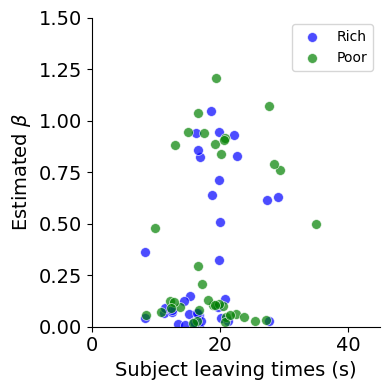

In [281]:
plot_fitted_parameter_vs_leave_time(res_soft_df, "vary_parameter_fix_c", "fitted_parameter")

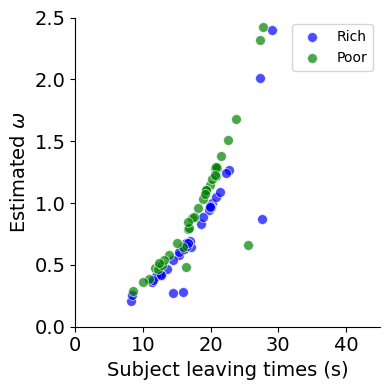

In [279]:
plot_fitted_parameter_vs_leave_time(res_mellow_df, "no_intercept", "fitted_parameter")

In [217]:
def calculate_aic_bic(n, rss, k):
    # Calculate log-likelihood
    ll = -n / 2 * (np.log(2 * np.pi * rss / n) + 1)
    
    # Calculate AIC and BIC
    aic = 2 * k - 2 * ll
    bic = k * np.log(n) - 2 * ll
    
    return aic, bic

# Function to calculate AIC and BIC for each subject
def calculate_subject_aic_bic(df, pred_col_name, k):
    results = []
    subjects = df['sub'].unique()
    
    for sub in subjects:
        sub_data = df[df['sub'] == sub]
        n = len(sub_data)
        rss = np.sum((sub_data['leaveT'] - sub_data[pred_col_name]) ** 2)
        aic, bic = calculate_aic_bic(n, rss, k)
        results.append({
            'sub': sub,
            'aic': aic,
            'bic': bic
        })
        
    results_df = pd.DataFrame(results)
    return results_df

In [220]:
patch_types = [
    {'type': 1, 'initial_yield': 32.5, 'decay_rate': 0.075},
    {'type': 2, 'initial_yield': 45, 'decay_rate': 0.075},
    {'type': 3, 'initial_yield': 57.5, 'decay_rate': 0.075}
]

In [291]:
def plot_bic(df_results, df_trials, policy_type):
    case_results = []
    for case in df_results.case.unique():
        case_df = df_results[df_results['case'] == case]

        # Calculate predicted leave times for each subject and patch type
        predicted_df = calculate_model_leave_times_for_patch_types(case_df, patch_types)

        merge_pred_df = pd.merge(df_trials, predicted_df, on=['sub', 'env', 'patch'])
        k = 1 if 'no_intercept' in case else 2
        bic_df = calculate_subject_aic_bic(merge_pred_df, 'predicted_leave_time', k)
        total_bic = bic_df['bic'].sum()
        
        case_results.append({
            'case': case,
            'total_bic': total_bic
        })

    summed_bic_df = pd.DataFrame(case_results)
    print(summed_bic_df)
    min_bic_value = summed_bic_df['total_bic'].min()
    best_case = summed_bic_df[summed_bic_df['total_bic'] == min_bic_value]['case'].iloc[0]

    plt.figure(figsize=(4, 4))

    # Plot all bars in pink, and the best one in a darker pink
    colors = ['#ff9999' if case != best_case else '#ff6666' for case in summed_bic_df['case']]

    plt.bar(summed_bic_df['case'], summed_bic_df['total_bic'] / 10**4, color=colors)

    best_case_bic = summed_bic_df[summed_bic_df['case'] == best_case]['total_bic'].values[0]
    plt.text(summed_bic_df[summed_bic_df['case'] == best_case].index[0], best_case_bic / 10**4 + 0.01, 
             f'{best_case_bic / 10**4:.2f}', ha='center', fontsize=15)
    
    plt.ylabel('Total BIC ($\\times 10^4$)', fontsize=15)
    plt.xticks(rotation=45, ha='right', fontsize=15)

    # Customize x-tick labels to display beta or omega in green
    if policy_type == "softmax":
        new_labels = ["fix beta fix c", "fix beta vary c", "vary beta fix c", "vary beta vary c", "c = 0"]
        x_labels = [label.replace("beta", r"${\beta}$") for label in new_labels]
    elif policy_type == "mellowmax":
        new_labels = ["fix omega fix c", "fix omega vary c", "vary omega fix c", "vary omega vary c", "c = 0"]
        x_labels = [label.replace("omega", r"${\omega}$") for label in new_labels]
    else:
        new_labels = summed_bic_df['case']  # Fallback to default if policy_type is not recognized

    plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=45, ha='right')

    # Remove top and right borders
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.ylim(1, 1.2)
    plt.tight_layout()
    plt.show()

/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:73: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(self.intercept + self.beta * reward))
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:73: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(self.intercept + self.beta * reward))


                    case     total_bic
0    fix_parameter_fix_c  11700.518547
1  vary_parameter_vary_c  11170.701829
2   vary_parameter_fix_c  11262.957558
3   fix_parameter_vary_c  11258.135883
4           no_intercept  17381.400897


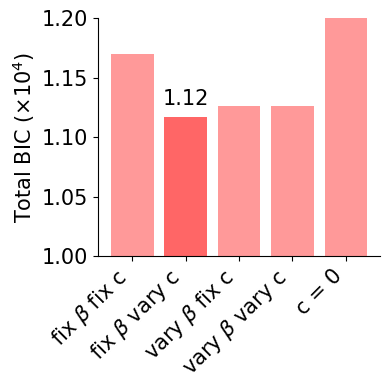

In [292]:
plot_bic(res_soft_df, df_trials, "softmax")

/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:108: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  beta_hat = fsolve(root_function, initial_guess)
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:93: RuntimeWarning: invalid value encountered in log
  return np.log(np.mean(np.exp(self.omega * Q_values) + self.intercept)) / self.omega
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:108: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  beta_hat = fsolve(root_function, initial_guess)
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:128: RuntimeWarning: overflow encountered in exp
  leave_proba = 1 / (1 + 

                    case     total_bic
0    fix_parameter_fix_c  11884.797205
1  vary_parameter_vary_c  11500.903911
2   vary_parameter_fix_c  11565.470419
3   fix_parameter_vary_c  11617.162529
4           no_intercept  11679.630574


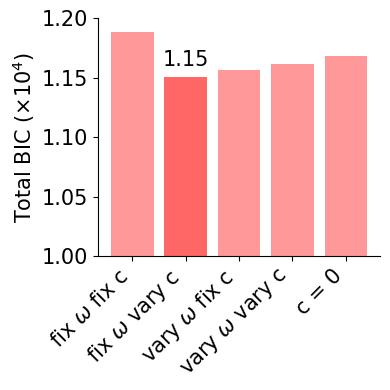

In [293]:
plot_bic(res_mellow_df, df_trials, "mellowmax")